## Brute-force diode parameter extraction

In [1]:
import os
import sys
sys.path.append('..')
IV_path = os.path.join('..', 'pvops', 'iv')
sys.path.append(IV_path)

from pvops.iv import simulator, extractor

### Step 1: Collect your IV curves. 

In this case, we simulate some curves, but you can replace this step by reading in your own data, if wanted.

In [2]:
sim = simulator.Simulator(
                mod_specs = {
                            'Jinko_Solar_Co___Ltd_JKM270PP_60': {'ncols': 6,
                                                                    'nsubstrings': 3
                                                                }
                            }
)

sim.build_strings({'Unstressed': ['pristine']*12})

N = 100
dicts = {'E':       {'mean': 800,
                        'std': 500,
                        'low': 400,
                        'upp': 1100
                    },
         'Tc':      {'mean': 30,
                      'std': 5,
                    },
         'Rs_mult': {'mean': 1.3,
                    'std': 0.6,
                    'low': 0.9,
                    'upp': 1.5
                    },
         'Rsh_mult': {'mean': 0.8,
                    'std': 0.9,
                    'low': 0.3,
                    'upp': 1.0
                    },
        'Il_mult': {'mean': 1.0,
                    'std': 0.5,
                    'low': 0.95,
                    'upp': 1.05
                    },
        'Io_mult': {'mean': 1.0,
                    'std': 0.6,
                    'low': 0.85,
                    'upp': 1.1
                    },
        'nnsvth_mult': {'mean': 1.0,
                        'std': 0.5,
                        'low': 0.85,
                        'upp': 1.1
                        }
        }
sim.generate_many_samples('pristine', N, dicts)
sim.simulate()

sim.print_info()

Simulating cells:   0%|                                                                          | 0/1 [00:00<?, ?it/s]c:\users\mwhopwo\appdata\local\programs\python\python36\lib\site-packages\scipy\optimize\zeros.py:463: RuntimeWarning: some failed to converge after 100 iterations
  warnings.warn(msg, RuntimeWarning)
Adding up other definitions: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2331.46it/s]

Condition list: (Cell definitions)
	[pristine]: 101 definition(s)

Modcell types: (Cell mappings on module)
	[pristine]: 1 definition(s)

String definitions (Series of modcells)
	[Unstressed]: 101 definition(s)



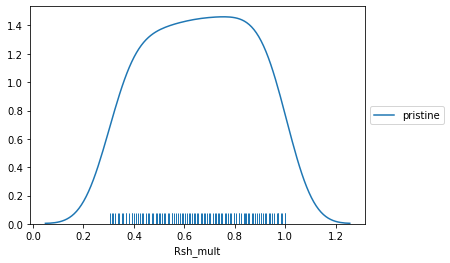

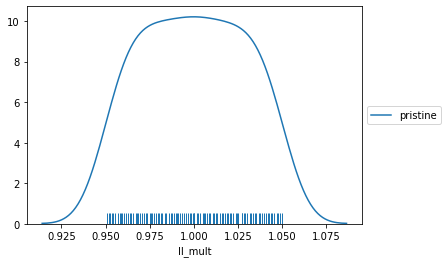

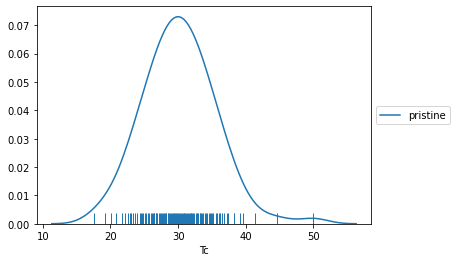

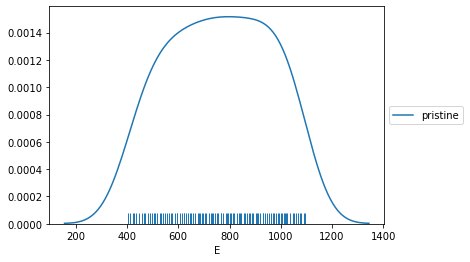

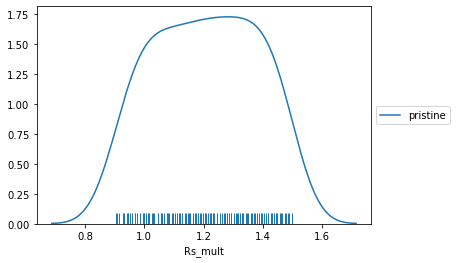

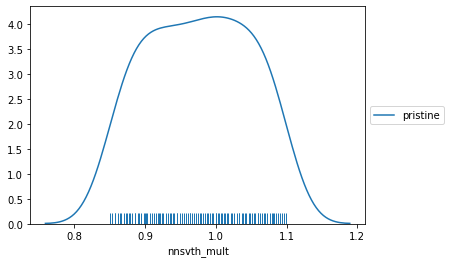

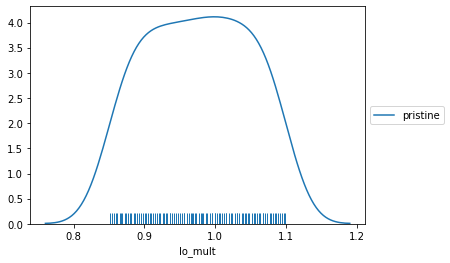

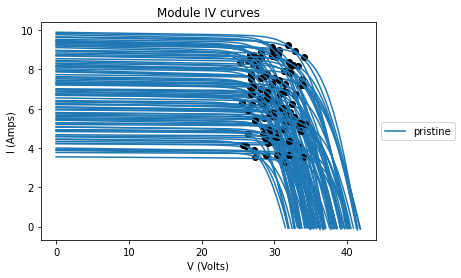

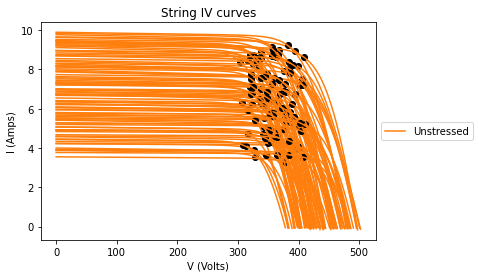

In [3]:
sim.visualize()

In [4]:
df = sim.sims_to_df(focus=['string'], cutoff=True)
df.head()

,current,voltage,E,T,mode,level
0,"[9.214203000284689, 9.210691359222285, 9.20726...","[3.834932371660216e-12, 11.207809937682319, 22...",1000.000000,50.000000,Unstressed,string
1,"[9.109951844384181, 9.102613181439972, 9.09545...","[3.838929174548866e-12, 10.36659467834228, 20....",981.560371,33.276588,Unstressed,string
2,"[9.628027499679503, 9.621304689122939, 9.61474...","[3.836708728499616e-12, 13.182100925676792, 26...",1049.873012,29.890905,Unstressed,string
3,"[6.749750836243313, 6.747054007353192, 6.74442...","[3.834932371660216e-12, 11.66093044667274, 23....",726.334474,28.186990,Unstressed,string
4,"[6.877008873267881, 6.872498175809985, 6.86809...","[3.834932371660216e-12, 11.618493244457234, 22...",749.444784,32.985619,Unstressed,string


### Step 2: Conduct diode parameter extraction

In [5]:
# Only created to retrieve cell_parameters
temporary_sim = simulator.Simulator(
                mod_specs = {
                            'Jinko_Solar_Co___Ltd_JKM270PP_60': {'ncols': 6,
                                                                    'nsubstrings': 3
                                                                }
                            }
)

extr = extractor.BruteForceExtractor(input_df=df, 
                              current_col='current',
                              voltage_col='voltage',
                              irradiance_col='E',
                              temperature_col='T',
                              T_type='cell',
                              windspeed_col=None,
                              Simulator_mod_specs=None,
                              Simulator_pristine_condition=None)

def bounds_func(iph,io,rs,rsh,nnsvth,perc_adjust=0.5):
    return ((iph - 0.5*iph*perc_adjust, iph + 2*iph*perc_adjust),
            (io - 100*io*perc_adjust, io + 100*io*perc_adjust),
            (rs - 20*rs*perc_adjust, rs + 20*rs*perc_adjust),
            (rsh - 150*rsh*perc_adjust, rsh + 150*rsh*perc_adjust),
            (nnsvth - 50*nnsvth*perc_adjust, nnsvth + 50*nnsvth*perc_adjust))

# Method to fit the parameters
# Currently computationally expensive.
# Issue 14 will create an alternative: https://github.com/tgunda/pvOps/tree/issue14

# extr.fit_params(temporary_sim.cell_parameters,
#                 n_mods=12,
#                 user_func=None,
#                 bounds_func=bounds_func,
#                 verbose=2)